In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error



In [2]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [3]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [4]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8480039,Martin Necas,Necas,C,CAR,81,R,0.610,0.620,0.602,0.597
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.456,0.428,0.401,0.436
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,77,L,0.434,0.441,0.437,0.433
3,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,0.463,0.442,0.425,0.466
4,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,0.509,0.503,0.487,0.490
...,...,...,...,...,...,...,...,...,...,...,...
466,8478400,Colin White,White,C,"PIT,MTL",28,R,0.471,0.500,0.504,0.482
467,8482652,Walker Duehr,Duehr,R,CGY,40,R,0.437,0.502,0.512,0.429
468,8479367,William Lockwood,Lockwood,R,FLA,26,R,0.550,0.524,0.485,0.530
469,8480068,Ryan Poehling,Poehling,C,PHI,77,L,0.481,0.451,0.497,0.524


In [5]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [6]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [7]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,81,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,77,3,0,5
3,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,5,2,2
4,8477989,Christian Dvorak,Dvorak,C,MTL,30,0,0,0
...,...,...,...,...,...,...,...,...,...
466,8477940,Nikolaj Ehlers,Ehlers,L,WPG,86,7,1,0
467,8480007,Jonas Rondbjerg,Rondbjerg,R,VGK,20,0,0,0
468,8479981,Jonah Gadjovich,Gadjovich,L,FLA,39,0,0,0
469,8482125,Alexander Holtz,Holtz,R,NJD,82,3,0,0


In [8]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [9]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [10]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,81,R,61.0,62.0,60.2,59.7,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,43.6,1,0,0
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,77,L,43.4,44.1,43.7,43.3,3,0,5
3,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,46.3,44.2,42.5,46.6,0,0,0
4,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,50.9,50.3,48.7,49.0,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,8478400,Colin White,White,C,PIT,28,R,47.1,50.0,50.4,48.2,0,0,0
467,8482652,Walker Duehr,Duehr,R,CGY,40,R,43.7,50.2,51.2,42.9,0,0,0
468,8479367,William Lockwood,Lockwood,R,FLA,26,R,55.0,52.4,48.5,53.0,0,0,0
469,8480068,Ryan Poehling,Poehling,C,PHI,77,L,48.1,45.1,49.7,52.4,1,0,3


In [11]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,471.000000,471.000000,471.000000,471.000000
mean,49.338429,49.383439,49.440977,49.344586
std,4.840937,5.297328,5.443231,4.923652
min,35.700000,34.100000,34.700000,34.400000
50%,49.800000,49.700000,49.500000,49.700000
75%,52.500000,52.900000,53.350000,52.700000
80%,53.100000,53.800000,54.400000,53.300000
90%,55.300000,56.200000,56.200000,55.000000
max,62.500000,62.100000,63.200000,61.700000


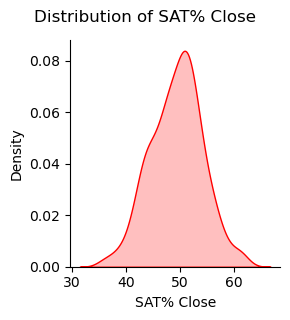

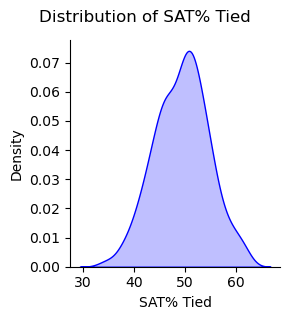

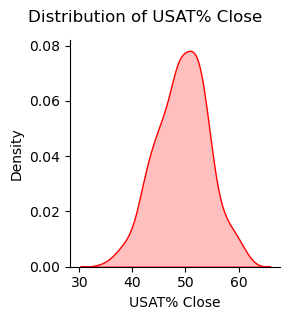

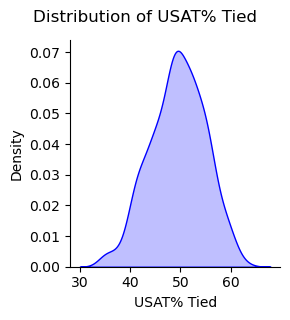

In [12]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageClose', fill=True, color='red')
satClose.fig.suptitle("Distribution of SAT% Close", y = 1.05)
satClose.set_xlabels("SAT% Close")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageTied', fill=True, color='blue')
satTied.fig.suptitle("Distribution of SAT% Tied", y = 1.05)
satTied.set_xlabels("SAT% Tied")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageClose', fill=True, color='red')
usatClose.fig.suptitle("Distribution of USAT% Close", y = 1.05)
usatClose.set_xlabels("USAT% Close")

usatTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageTied', fill=True, color='blue')
usatTied.fig.suptitle("Distribution of USAT% Tied", y = 1.05)
usatTied.set_xlabels("USAT% Tied")

In [13]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,471.000000,471.000000,471.000000
mean,2.225053,0.318471,0.450106
std,2.332082,0.678279,0.848751
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,12.000000,3.000000,6.000000


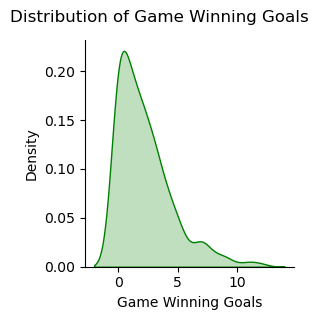

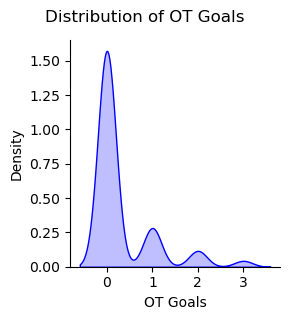

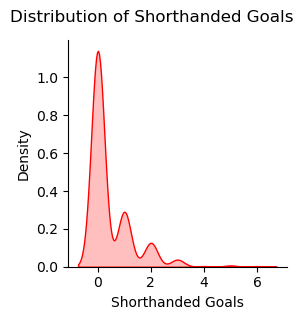

In [14]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'gameWinningGoals', fill=True, color='green')
satClose.fig.suptitle("Distribution of Game Winning Goals", y = 1.05)
satClose.set_xlabels("Game Winning Goals")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'otGoals', fill=True, color='blue')
satTied.fig.suptitle("Distribution of OT Goals", y = 1.05)
satTied.set_xlabels("OT Goals")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'shGoals', fill=True, color='red')
usatClose.fig.suptitle("Distribution of Shorthanded Goals", y = 1.05)
usatClose.set_xlabels("Shorthanded Goals")

In [15]:
satCloseQuantile = df_players_merged['satPercentageClose'].quantile(0.9)
satTiedQuantile = df_players_merged['satPercentageTied'].quantile(0.9)
usatCloseQuantile = df_players_merged['usatPercentageClose'].quantile(0.9)
usatTiedQuantile = df_players_merged['usatPercentageTied'].quantile(0.9)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= satCloseQuantile) or (row['satPercentageTied'] >= satTiedQuantile) or (row['usatPercentageClose'] >= usatCloseQuantile) or (row['usatPercentageTied'] >= usatTiedQuantile)
    if clutchness:
        return 1
    else:
        return 0

df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [16]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    396
1     75
Name: count, dtype: int64

In [17]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.35)
model = RandomForestClassifier(n_estimators=100)
model.fit(train[x_var], train[y_var].values.ravel())

test['clutch_type'] = model.predict(test[x_var])
test['correct'] = (test['clutch_type'] == test['clutch_performance'])

test['correct'].mean()

0.9696969696969697

In [18]:
probs = DataFrame(model.predict_proba(test[x_var]), index=test.index, columns=model.classes_)
probs

,0,1
44,0.95,0.05
359,1.00,0.00
171,0.54,0.46
18,1.00,0.00
360,0.99,0.01
...,...,...
25,1.00,0.00
330,1.00,0.00
469,1.00,0.00
379,0.99,0.01


In [19]:
model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)

In [20]:
scores

array([1.        , 1.        , 0.9787234 , 1.        , 1.        ,
       0.93617021, 1.        , 1.        , 0.9787234 , 1.        ])

In [21]:
scores.mean()

0.9893617021276595

In [22]:
precision = precision_score(test[y_var], test['clutch_type'])
recall = recall_score(test[y_var], test['clutch_type'])
f1 = f1_score(test[y_var], test['clutch_type'])

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9285714285714286
Recall: 0.896551724137931
F1 Score: 0.912280701754386


In [23]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train[x_var], train[y_var].values.ravel())

probs = model.predict_proba(test[x_var])[:, 1]

auc = roc_auc_score(test[y_var], probs)

print("AUC Score:", auc)

AUC Score: 0.9970841784989858


In [24]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

balanced_accuracy

0.9754056795131847

In [25]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]  

conf_matrix = confusion_matrix(y_true, y_pred, normalize="all")

conf_matrix

array([[0.81212121, 0.01212121],
       [0.00606061, 0.16969697]])

In [26]:
x_test = test[x_var]
y_true = test[y_var]

y_pred = model.predict(x_test)

mse = mean_squared_error(y_true, y_pred)

mse

0.01818181818181818